In [1]:
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sigpy as sp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import os
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import pickle as pkl


ModuleNotFoundError: No module named 'skimage'

In [2]:
def delete_zeros(kspace):
    ## function to remove extra zeros in knees
    # Compute sum-energy of lines
    # !!! This is because some lines are near-empty
    line_energy = np.sum(np.square(np.abs(kspace)),
                         axis=(0, 1))
    dead_lines  = np.where(line_energy < 1e-12)[0] # Sufficient for FP32
    # Always remove an even number of lines
    dead_lines_front = np.sum(dead_lines < 160)
    dead_lines_back  = np.sum(dead_lines > 160)
    if np.mod(dead_lines_front, 2):
        dead_lines = np.delete(dead_lines, 0)
    if np.mod(dead_lines_back, 2):
        dead_lines = np.delete(dead_lines, -1)
    # Remove dead lines completely
    k_image = np.delete(kspace, dead_lines, axis=-1)
    return k_image

def get_mvue(kspace, s_maps):
    # convert from k-space to mvue
    return np.sum(sp.ifft(kspace, axes=(-1, -2)) * np.conj(s_maps), axis=0) / np.sqrt(np.sum(np.square(np.abs(s_maps)), axis=0))

def img_mvue(x, s_maps):
    # convert from image to mvue
    coils = s_maps * x[None, ...] 
    mvue = np.sum(coils * np.conj(s_maps), axis=0) / np.square(np.linalg.norm(s_maps, axis=0))
    return mvue

def img_rss(x, s_maps):
    # convert from image to rss
    coils = s_maps * x[None, ...] 
    rss  = sp.rss(coils, axes=(0,))
    return rss

# Brain plots

## Map estimation

Uncomment the following code block if you need to estimate the maps. Change the input and output directory arguments accordingly.

In [5]:
# !python estimate_maps --input-dir=datasets/brain_T2 --output-dir=datasets/brain_T2_maps

## Get ground-truth MVUE for Brains

fastMRI data is of shape 768x392 in the k-space domain, and is cropped to 384x384 in the image domain

In [3]:
brain_slice_idx = 0
brain_shape = (384, 384)

# load kspace data and maps
with h5py.File( '../datasets/brain_T2/file_brain_AXT2_200_2000019.h5') as f:
    brain_kspace = np.array( f['kspace'] )[brain_slice_idx]
    
    
with h5py.File( '../datasets/brain_T2_maps/file_brain_AXT2_200_2000019.h5') as f:
    brain_smaps = np.array( f['s_maps'] )[brain_slice_idx]

# compute mvue
brain_mvue = get_mvue( brain_kspace, brain_smaps )

# crop in image domain
brain_mvue = sp.resize( brain_mvue, brain_shape )



## Load brain reconstruction

In [4]:
# this file name will have to be changed depending on your experiment
#rec_file = f'outputs/2021-07-22/11-05-14/file_brain_AXT2_200_2000019.h5|langevin|slide_idx_{brain_slice_idx}_R=4_outputs.pt'
# rec_file = '../datasets/brain_T2_maps/file_brain_AXT2_200_2000019.h5'
rec_file = 'outputs/2022-09-29/11-57-11/file_brain_AXT2_200_2000019.h5|langevin|slide_idx_0_R=4_outputs.pt'
brain_rec_ = torch.load( rec_file )['mvue']
# brain_rec= h5py.File(rec_file)
# brain_rec_= np.array(brain_rec['s_maps'])
brain_rec_ = brain_rec_.detach().cpu().numpy()
brain_rec = brain_rec_[0,0] + 1j * brain_rec_[0,1]



## Process reconstruction

Our reconstructions have shape 384x384. However, fastMRI data is of shape 768x392 in the k-space domain that is later cropped to 384x384 in the image domain. In order to match the resolutions, we need to pad in the k-space domain, do an IFFT, and then crop.

Typical end-to-end methods don't need to do this as they produce images of shape 768x392, and hence can crop to 384x384 directly in the image domain.

In [5]:
rec = sp.resize( brain_rec, (768, 384) ) # resize to fastMRI size in readout
rec = sp.fft( rec, axes=(-1,) ) # go to kspace in phase-encode
rec = sp.resize( rec, (768, brain_smaps.shape[-1]) ) # resize to fastMRI size in phase-encode
rec = sp.ifft( rec , axes=(-1,) ) # convert back to image domain

# get mvue and crop
brain_rec = img_mvue(rec, brain_smaps)
brain_rec = sp.resize( brain_rec, (384, 384) )

## Plot ground truth and reconstruction

Image must be flipped vertically since fastMRI has kspace upside down


Text(0.5, 1.0, 'Reconstructed MVUE, R=4')

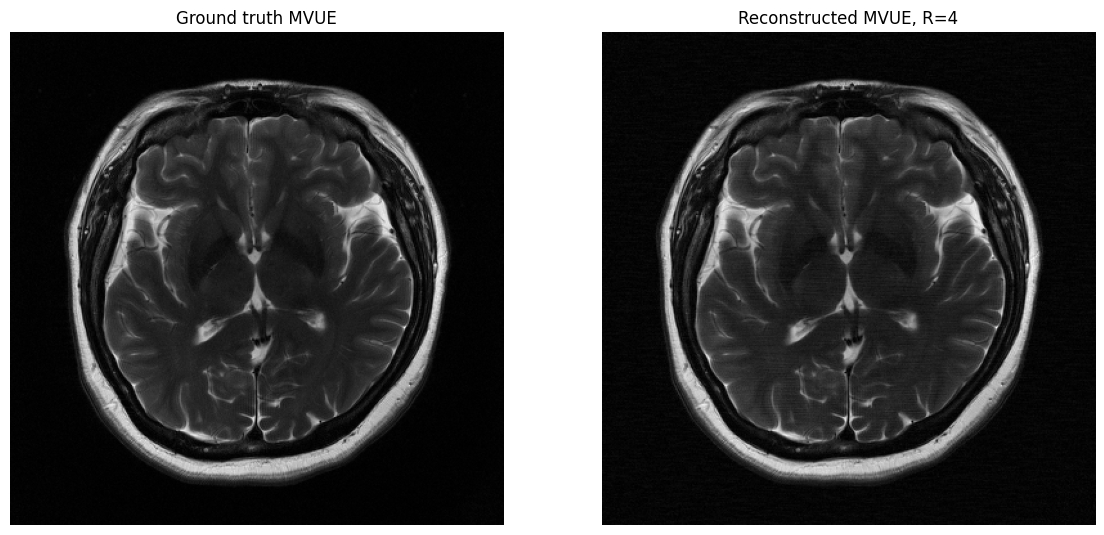

In [6]:
_, ax = plt.subplots( 1, 2, figsize=(14,7))

ax[0].imshow( np.abs(brain_mvue[::-1,]), cmap='gray')
ax[1].imshow( np.abs(brain_rec[::-1,]), cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title( 'Ground truth MVUE')
ax[1].set_title( 'Reconstructed MVUE, R=4')

In [10]:
plt.close()

# Knee plots

## load ground truth and estimate MVUE

In [7]:
knee_slice_idx = 1
with h5py.File( './datasets/knees/file1000031.h5', 'r') as f:
    knees_kspace = np.array( f['kspace'] )[knee_slice_idx]
with h5py.File( './datasets/knees_maps/file1000031.h5', 'r') as f:
    knees_smaps = np.array( f['s_maps'] )[knee_slice_idx]
knees_mvue = get_mvue( knees_kspace, knees_smaps)
knees_mvue = sp.resize( knees_mvue, (320,320) )

## Load reconstructions

In [8]:
# this file name will have to be changed depending on your experiment
rec_file = f'outputs/2022-09-30/11-52-01/file1000031.h5|langevin|slide_idx_{knee_slice_idx}_R=4_outputs.pt'
knees_rec_ = torch.load( rec_file )['mvue']
knees_rec_ = knees_rec_.detach().cpu().numpy()
knees_rec = knees_rec_[0,0] + 1j * knees_rec_[0,1]



## Process reconstructions

Our reconstructions have shape 320x320. However, fastMRI data is of shape 640x332 in the k-space domain that is later cropped to 320x320 in the image domain. In order to match the resolutions, we need to pad in the k-space domain, do an IFFT, and then crop.

Typical end-to-end methods don't need to do this as they produce images of shape 640x332, and hence can crop to 320x320 directly in the image domain.

In [9]:
rec = sp.resize( knees_rec, (knees_smaps.shape[-2], 320) ) # resize to fastMRI size in readout
rec = sp.fft( rec, axes=(-1,) ) # go to kspace in phase-encode
rec = sp.resize( rec, (knees_smaps.shape[-2], knees_smaps.shape[-1]) ) # resize to fastMRI size in phase-encode
rec = sp.ifft( rec , axes=(-1,) ) # convert back to image domain

# get mvue and crop
knees_rec = img_mvue(rec, knees_smaps)
knees_rec = sp.resize( knees_rec, (320, 320) )

Text(0.5, 1.0, 'Reconstructed MVUE, R=4')

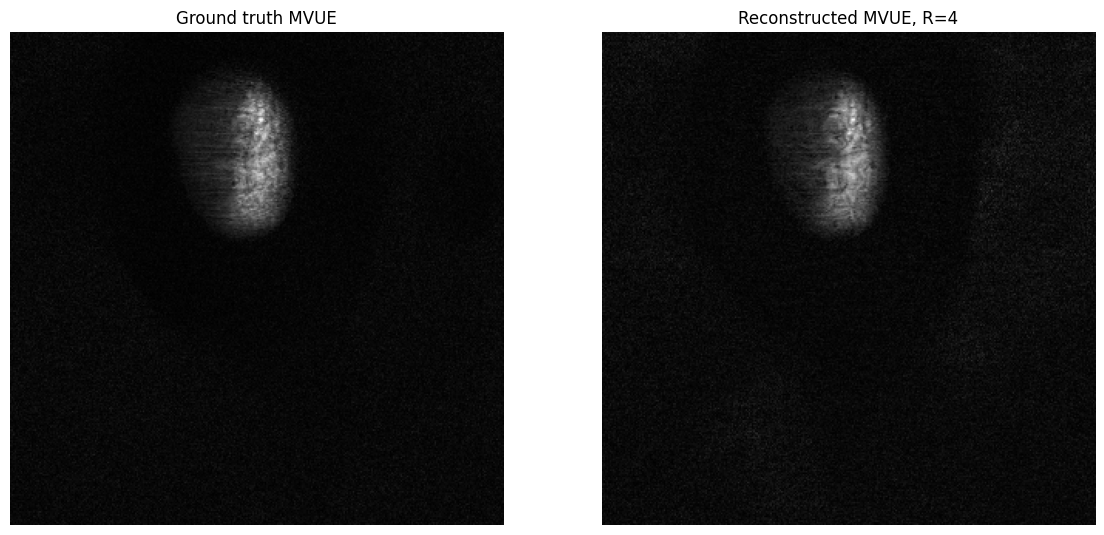

In [10]:
_, ax = plt.subplots( 1,2, figsize=(14,7))
ax[0].imshow( np.abs(knees_mvue[::-1,::-1]) , cmap='gray')
ax[1].imshow( np.abs(knees_rec[::-1,::-1]) , cmap='gray')
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Ground truth MVUE')
ax[1].set_title( 'Reconstructed MVUE, R=4')

In [15]:
plt.close()

# Stanford knees

In [46]:
stanford_slice_idx = 1
with h5py.File('./datasets/stanford_knees_axial/Stanford-Knee-Axial-P13-R9.97-Selected.h5', 'r') as data:
    stanford_kspace, stanford_maps = np.array(data['kspace'])[stanford_slice_idx], np.array(data['s_maps'])[stanford_slice_idx]
    stanford_mvue = get_mvue(stanford_kspace, stanford_maps)


In [48]:
# this file name will have to be changed depending on your experiment
stanford_rec_file = f'outputs/2022-09-30/11-52-01/Stanford-Knee-Axial-P13-R9.97-Selected.h5|langevin|slide_idx_{stanford_slice_idx}_R=4_outputs.pt'
states = torch.load(stanford_rec_file)
rec_ = states['mvue'].cpu().numpy()
stanford_rec = rec_[0,0] + 1j * rec_[0,1]

stanford_rec = img_mvue( stanford_rec, stanford_maps )

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/2022-09-30/11-52-01/Stanford-Knee-Axial-P13-R9.97-Selected.h5|langevin|slide_idx_1_R=4_outputs.pt'

Text(0.5, 1.0, 'Reconstructed MVUE')

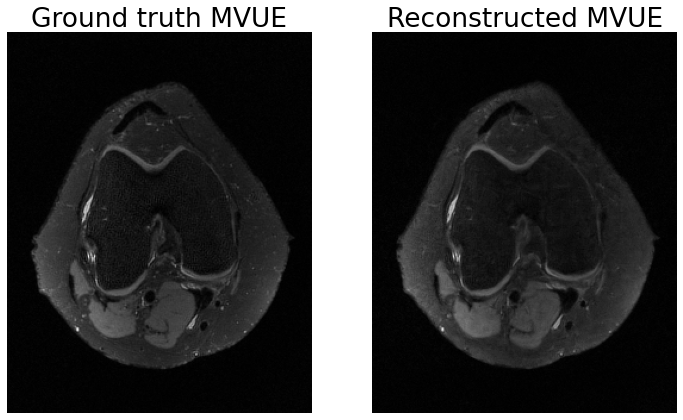

In [32]:
_, ax = plt.subplots( 1, 2 , figsize=(12,8))
ax[0].imshow( np.abs( stanford_mvue ), cmap='gray')
ax[1].imshow( np.abs( stanford_rec ), cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Ground truth MVUE')
ax[1].set_title('Reconstructed MVUE')

# Abdominal MRI

In [47]:
abs_slice_idx = 9
with h5py.File('./datasets/abdomens/data2.h5', 'r') as f:
    abs_kspace = np.array(f['ksp'])[abs_slice_idx]
    abs_maps = np.array(f['maps'])[abs_slice_idx]

# find mvue image
abs_mvue = get_mvue(abs_kspace, abs_maps)

## Process reconstructions

We initially cropped the reconstructions to 192x320 as our generative model could only handle shapes that are multiples of 64. We have since patched this and the cropping is no longer necessary using our latest code. We have reproduced the cropping for completeness.

In [48]:
abs_rec_file = f'./outputs/2021-05-28/01-08-44/{abs_slice_idx}|langevin|slide_idx_{abs_slice_idx+1}_R=4_outputs.pt'
states = torch.load(abs_rec_file)
rec_ = states['mvue'].cpu().numpy()
abs_rec = rec_[0,0] + 1j * rec_[0,1]
ksp = sp.fft(abs_rec, axes=(-1,-2))
ksp = sp.resize(ksp, (158, 320))
abs_rec = sp.ifft(ksp, axes=(-1,-2))

abs_rec = img_mvue( abs_rec, abs_maps )

Text(0.5, 1.0, 'Reconstructed MVUE')

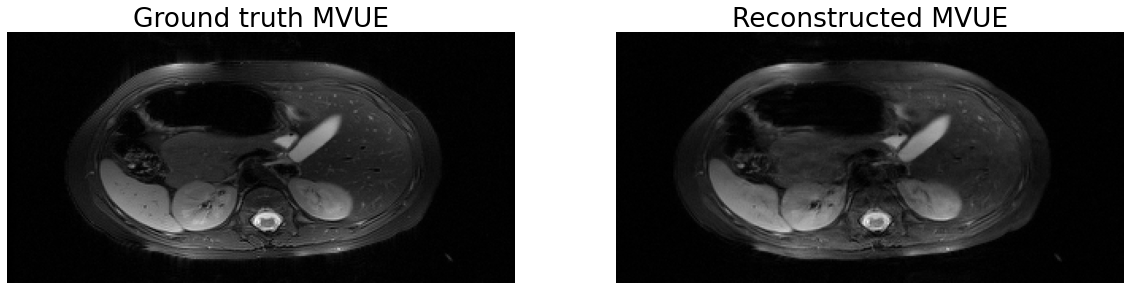

In [50]:
_, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow( np.abs( abs_mvue ), cmap='gray')
ax[1].imshow( np.abs( abs_rec ) , cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Ground truth MVUE')
ax[1].set_title('Reconstructed MVUE')